In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, FK5

import aplpy

from spectral_cube import SpectralCube
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord

import pyregion
from pyregion.mpl_helper import properties_func_default


%matplotlib inline

/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Extract GASKAP pilot region from GASSIII cubes

Creates a cutout subcube covering the GASKAP pilot region: 

Field centres of the three fields are:
* 02:37:52.462	-74:23:18.20
* 01:50:15.423	-70:16:38.02
* 00:58:43.280	-72:31:49.03

Target is 240x240 pixels around RA=01:40, Dec=-73:50


In [2]:
def calc_plane_velocity(header, plane):
    vel_step = (header['CDELT3'] *u.m/u.s).to(u.km / u.s)
    low_val = ((header['CRVAL3'] - (header['CRPIX3']-1)*header['CDELT3']) * u.m/u.s).to(u.km/u.s)
    plane_vel = (low_val + (plane-1)*header['CDELT3']*u.m/u.s).to(u.km/u.s)
    return plane_vel

    
def get_non_mw_vel_index_range(header):
    mw_max = 18 *u.km / u.s
    mw_min = -30*u.km / u.s
    vel_step = (header['CDELT3'] *u.m/u.s).to(u.km / u.s)
    low_val = ((header['CRVAL3'] - (header['CRPIX3']-1)*header['CDELT3']) * u.m/u.s).to(u.km/u.s)
    high_val = (low_val + (header['NAXIS3']-1)*header['CDELT3']*u.m/u.s).to(u.km/u.s)
    high_val_2 = calc_plane_velocity(header, header['NAXIS3'])

    print("Cube covers velocity range of ", low_val, high_val, high_val_2)
    low_idx = 1
    high_idx = header['NAXIS3']

    if (low_val < mw_max and high_val > mw_min):
        if (high_val < mw_max):
            high_idx = int(np.ceil((mw_min - low_val) / vel_step))
        else:
            low_idx_flt = np.floor((high_val - mw_max) / vel_step)
            low_idx = header['NAXIS3']-int(np.floor((high_val - mw_max) / vel_step))
            print (low_idx_flt, low_idx)
        print ("Filtering included planes to ", low_idx, high_idx)
        print ("Filtering velocity range to", calc_plane_velocity(header, low_idx), calc_plane_velocity(header, high_idx))


    return low_idx-1, high_idx-1

def report_velocity_range(header):
    vel_step = (header['CDELT3'] *u.m/u.s).to(u.km / u.s)
    low_val = calc_plane_velocity(header, 0)
    high_val = calc_plane_velocity(header, header['NAXIS3'])

    print("Cube covers velocity range of {:.3f} to {:.3f}".format(low_val, high_val))



In [3]:
centre = SkyCoord('01:40', '-73:50', FK5, unit=(u.hourangle, u.deg))
print(centre)


<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (25., -73.83333333)>


In [4]:
# Strategy:
# 1. Extract subset of interest from each spectral slab, save to file
# 2. Combine all for spectral range of interest - careful of overlap

full_subcube = None
min_subcube = 99
max_subcube = 0
header = None

    
xpix=0
ypix=0
width = int(240/2)
height = int(240/2)
refpos = None

for i in range(1,21):
    filename = 'gass_{:02d}.zea.fits'.format(i)
    path = 'GASSIII/ZEA_CUBES/' + filename
    print(path)
    hdr = fits.open(path)
    wcs = WCS(hdr[0].header)
    data = hdr[0].data
    if i == 1:
        xpix,ypix=centre.to_pixel(wcs,origin=0,mode='all')
        xpix=int(xpix)
        ypix=int(ypix)
        print ("Extracting a region of {:d}x{:d} centred on pix {:d}, {:d}".format(width*2, height*2, xpix, ypix))

        refpos = pixel_to_skycoord(xpix, ypix, wcs, origin=0, mode='all')
        print (refpos)
        print (wcs)
    report_velocity_range(hdr[0].header)
    #print(hdr[0].header['CRVAL3'], hdr[0].header['CRPIX3'], hdr[0].header['CDELT3'], hdr[0].header['NAXIS3'])

    subset = data[:,ypix-height:ypix+height,xpix-width:xpix+width]
    
    if full_subcube is None:
        full_subcube = subset[:,:,:]
        print(full_subcube.shape, type(full_subcube))
        header = hdr[0].header
    else:
        full_subcube = np.append(full_subcube, subset[:,:,:], axis=0)
        print(full_subcube.shape, type(full_subcube))
    if i < min_subcube:
        min_subcube = i
    max_subcube = i

print(full_subcube.shape) 

# Setup a new reference location for the WCS
header['NAXIS1'] = width
header['NAXIS2'] = height
header['CRPIX1'] = header['CRPIX1'] - xpix +width
header['CRPIX2'] = header['CRPIX2'] - ypix +height

#header['CRPIX1'] = 1+width
#header['CRPIX2'] = 1+height
#header['CRVAL1'] = refpos.ra.value
#header['CRVAL2'] = refpos.dec.value
print(header)

hdu = fits.PrimaryHDU(full_subcube)
hdu.header = header
hdl = fits.HDUList([hdu])
hdl.writeto('gaskap_pilot_cutout.fits', overwrite=True)
print (WCS(hdu.header))





GASSIII/ZEA_CUBES/gass_01.zea.fits


Extracting a region of 240x240 centred on pix 1038, 1306
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (25.29202116, -73.84285406)>
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---ZEA'  'DEC--ZEA'  'VOPT'  
CRVAL : 0.0  -90.0  -499647.003174  
CRPIX : 1125.0  1125.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.08  0.08  824.500024319  
NAXIS : 2250  2250  61
Cube covers velocity range of -500.472 km / s to -450.177 km / s
(61, 240, 240) <class 'numpy.ndarray'>
GASSIII/ZEA_CUBES/gass_02.zea.fits
Cube covers velocity range of -451.002 km / s to -399.883 km / s
(123, 240, 240) <class 'numpy.ndarray'>
GASSIII/ZEA_CUBES/gass_03.zea.fits
Cube covers velocity range of -400.707 km / s to -349.588 km / s
(185, 240, 240) <class 'numpy.ndarray'>
GASSIII/ZEA_CUBES/gass_04.zea.fits
Cube covers velocity range of -350.413 km / s to -300.118 km / s
(246, 240, 240) <class 'numpy.ndarray'>
GASSIII/ZEA_CUBES/gas

In [5]:
cube = SpectralCube.read('gaskap_pilot_cutout.fits')
mom0 = cube.moment0()
#header = mom0.header
#data = mom0.data[:]
hdu = mom0.hdu
mom0.write('gaskap_pilot_cutout_mom0.fits', overwrite=True)



/Users/jamesdempsey/anaconda/envs/python3/lib/python3.6/site-packages/spectral_cube/spectral_cube.py:246: UserWarning: Could not parse beam information from header.  Exception was: NoBeamException('No BMAJ found and does not appear to be a CASA/AIPS header.',)
  "  Exception was: {0}".format(ex.__repr__()))


In [6]:
r = pyregion.open('pilottilefield_notext.reg')
for reg in r:
    reg.coord_format = 'fk5'
#r[0].coord_format
r2 = r.as_imagecoord(hdu.header)

def fixed_color(shape, saved_attrs):
    attr_list, attr_dict = saved_attrs
    attr_dict["color"] = "yellow"
    kwargs = properties_func_default(shape, (attr_list, attr_dict))

    return kwargs

patch_list, artist_list = r2.get_mpl_patches_texts(fixed_color)


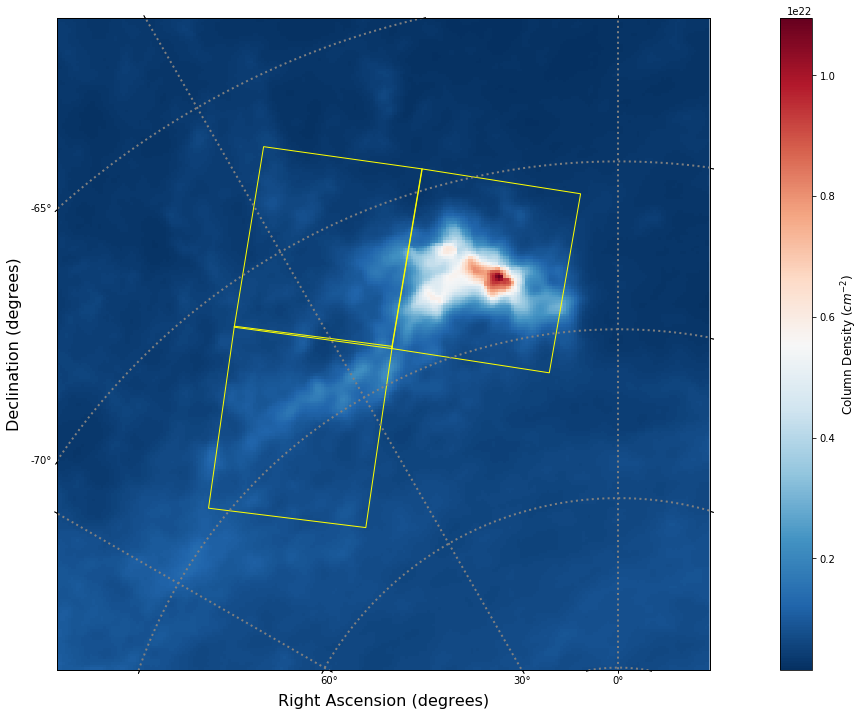

In [7]:
# Initiate a figure and axis object with WCS projection information
wcs = WCS(hdu.header)
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=wcs)

# Display the moment map image
#im = ax.imshow(hi_data[0].data, cmap='RdBu_r') #, vmin=0, vmax=2e21)

im = ax.imshow(hdu.data * 1.82 * 10**18 /1000, cmap='RdBu_r') #, vmin=0, vmax=2e21)
ax.invert_yaxis()  # Flips the Y axis
#ax.invert_xaxis()  # Flips the Y axis

for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)    



# Add axes labels
ax.set_xlabel("Right Ascension (degrees)", fontsize=16)
ax.set_ylabel("Declination (degrees)", fontsize=16)

ax.grid(color = 'gray', ls = 'dotted', lw = 2)


# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Column Density ($cm^{-2}$)', size=12)
#ax.show()
#plt.close()
plt.savefig('gaskap_pilot_cutout_mom0.pdf', bbox_inches='tight', pad_inches=0)
